CLEANING

In [ ]:
# Install necessary packages
!pip install pandas nltk Sastrawi requests

# Import necessary libraries
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import os
import requests
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# URL of the dataset
url = 'https://raw.githubusercontent.com/AxelTheAxcelian/Capstone_Project/main/Dataset/Dataset_Capstone%20-%20Merge.csv'

# Check if the URL is accessible
response = requests.get(url)
if response.status_code != 200:
    raise FileNotFoundError(f"File not found: {url}")

# Load the dataset
df = pd.read_csv(url)
print(df.columns)  # Debugging: Check the column names

# Ensure 'sentences' column exists
if 'sentences' not in df.columns:
    raise KeyError("'sentences' column not found in the dataset")

# Convert the 'sentences' column to string type
df['sentences'] = df['sentences'].astype(str)

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove special characters specific to Twitter
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # Remove hashtags
    text = re.sub(r'RT[\s]+', '', text)  # Remove retweets

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove non-ASCII characters
    text = ''.join(char for char in text if ord(char) < 128)

    # Remove repeated characters (e.g., 'helloooo' to 'hello')
    text = re.sub(r'(.)\1+', r'\1', text)

    # Remove emoticons
    emoticons = re.findall(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', '', text)

    # Case folding (convert text to lowercase)
    text = text.lower()

    # Tokenize text
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('indonesian'))  # Use Indonesian stopwords
    words = [word for word in words if word not in stop_words]

    # Join words back into a string
    cleaned_text = ' '.join(words)

    return cleaned_text

# Apply the clean_text and stemmingIndo functions to the 'sentences' column
df['cleaned_text'] = df['sentences'].apply(clean_text)

# Display the cleaned dataset
print(df['cleaned_text'])

# Select relevant columns and save to CSV
df_clean = df[['cleaned_text', 'label']]

# Save the cleaned DataFrame to a CSV file
df_clean.to_csv('df_clean.csv', index=False)

# Download the file (only works in Google Colab)
from google.colab import files
files.download('df_clean.csv')


In [ ]:
#sastrawi
def stemmingIndo(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return stemmer.stem(text)

# Apply the clean_text and stemmingIndo functions to the 'sentences' column
df['cleaned_text'] = df['sentences'].apply(stemmingIndo)

# Display the cleaned dataset
print(df['cleaned_text'])

Model

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
data = pd.read_csv('/content/df_clean.csv')

In [ ]:
data

,cleaned_text,label
0,engak jenuh,0
1,aslinya cantik ayu loh mbak krn bertemu langsu...,0
2,astagfirulah mbak tolong ucapanya dijaga ya al...,0
3,aurel cantik tau liat asli nya org sirik yg me...,0
4,dapatkan voucher pulsa rp orang beruntung nya ...,0
...,...,...
7238,utamakan prediksi bosku nikmati promo bonus me...,3
7239,thailand tangal kamis mei result shio babi sel...,3
7240,toto macau mei result sah shio kambing link li...,3
7241,user id r selamat kemenanganya pencarian gogle...,3


In [ ]:
# Check untuk missing values
data['cleaned_text'] = data['cleaned_text'].astype(str)

# drop missing values
data['cleaned_text'].fillna('', inplace=True)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

# Tokenize the text
tokenizer = Tokenizer(num_words=5000, split=' ')
tokenizer.fit_on_texts(data['cleaned_text'].values)
X = tokenizer.texts_to_sequences(data['cleaned_text'].values)
X = pad_sequences(X)

# Convert labels to categorical
num_classes = len(np.unique(data['label']))
Y = to_categorical(data['label'], num_classes=num_classes)

# Split the data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(Y)


[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [ ]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=X.shape[1]))  # Adjust embedding dimensions if needed
model.add(SpatialDropout1D(0.2))
model.add(LSTM(60, return_sequences=True, recurrent_dropout=0.2))  # Consider recurrent dropout for LSTMs
model.add(Dropout(0.3))  # Experiment with different dropout rates
model.add(LSTM(32))  # Reduce LSTM units if complexity is high
model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01)))  # Adjust weight decay

In [ ]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
batch_size = 32
epochs = 30

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=2, callbacks=[early_stopping])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 85, 128)           640000    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 85, 128)           0         
 alDropout1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 85, 60)            45360     
                                                                 
 dropout_1 (Dropout)         (None, 85, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                11904     
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                      

In [ ]:
model.evaluate(X, Y)

227/227 [==============================] - 2s 8ms/step - loss: 0.3567 - accuracy: 0.8998


[0.35673853754997253, 0.8997653126716614]

In [ ]:
def predict_sentiment(tweet):
    tweet_seq = tokenizer.texts_to_sequences([tweet])
    tweet_pad = pad_sequences(tweet_seq, maxlen=X.shape[1])
    prediction = model.predict(tweet_pad)
    predicted_label = np.argmax(prediction, axis=1)
    original_label = label_encoder.inverse_transform(predicted_label)

    return original_label[0]

test_tweet = "aku punya anjing"
print("Predicted label:", predict_sentiment(test_tweet))

1/1 [==============================] - 0s 35ms/step
Predicted label: 1


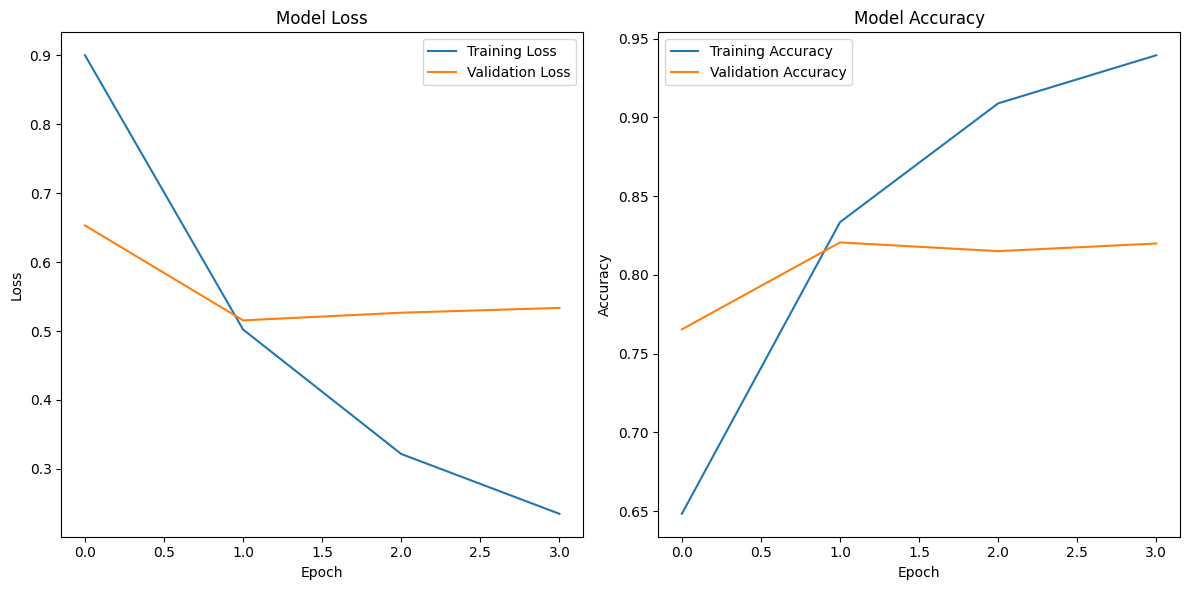

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

Nyobain Save Model ke tflite

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt

data = pd.read_csv('https://raw.githubusercontent.com/AxelTheAxcelian/Capstone_Project/main/Hate%20speech%20data.csv/df_clean_stop.csv')

data['cleaned_text'] = data['cleaned_text'].astype(str)
data['cleaned_text'].fillna('', inplace=True)

label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

tokenizer = Tokenizer(num_words=5000, split=' ')
tokenizer.fit_on_texts(data['cleaned_text'].values)
X = tokenizer.texts_to_sequences(data['cleaned_text'].values)
X = pad_sequences(X)

Y = to_categorical(data['label'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(60, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax', kernel_regularizer=l2(0.01)))

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 10
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=2, callbacks=[early_stopping])

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Simpan model dalam format HDF5
model.save('hate_speech_model.h5')

# Muat kembali model HDF5
loaded_model = tf.keras.models.load_model('hate_speech_model.h5')

# Konversi model HDF5 ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Simpan model TensorFlow Lite ke file
with open('hate_speech_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Muat model TensorFlow Lite
interpreter = tf.lite.Interpreter(model_path='hate_speech_model.tflite')
interpreter.allocate_tensors()

# Dapatkan detail input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [ ]:
def predict_sentiment_tflite(tweet):
    tweet_seq = tokenizer.texts_to_sequences([tweet])
    tweet_pad = pad_sequences(tweet_seq, maxlen=X.shape[1])

    input_data = np.array(tweet_pad, dtype=np.float32)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    prediction = interpreter.get_tensor(output_details[0]['index'])

    predicted_label = np.argmax(prediction, axis=1)
    original_label = label_encoder.inverse_transform(predicted_label)

    return original_label[0]

test_tweet = "bodoh"
print("Predicted label (TFLite):", predict_sentiment_tflite(test_tweet))